In [43]:
greetings = "Assalam-o-Alaikum!"
print(greetings)

Assalam-o-Alaikum!


### Import Libraries

In [70]:
import pandas as pd
import numpy as np

from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.neighbors import KNeighborsClassifier
from sklearn.decomposition import PCA
from sklearn.naive_bayes import GaussianNB
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
import re

# Feature Engineering

In [45]:
df_h = pd.read_json("hiking.json")
df_h[:2]

,Prop_ID,Name,Location,Park_Name,Length,Difficulty,Other_Details,Accessible,Limited_Access,lat,lon
0,B057,Salt Marsh Nature Trail,"Enter behind the Salt Marsh Nature Center, loc...",Marine Park,0.8 miles,None,<p>The first half of this mile-long trail foll...,Y,N,NaN,NaN
1,B073,Lullwater,Enter Park at Lincoln Road and Ocean Avenue en...,Prospect Park,1.0 mile,Easy,Explore the Lullwater to see how nature thrive...,N,N,NaN,NaN


### Encoding categorical variables - binary

In [46]:
# Set up the LabelEncoder object
enc = LabelEncoder()

# Apply the encoding to the "Accessible" column
df_h["Accessible_env"] = enc.fit_transform(df_h["Accessible"])

# Compare the two columns
df_h[["Accessible", "Accessible_env"]][::6]

,Accessible,Accessible_env
0,Y,1
6,N,0
12,N,0
18,N,0
24,N,0
30,N,0


### Engineering features from strings - extraction

In [47]:
df_h["Length"] = df_h["Length"].astype("str")

In [48]:
# Write a pattern to extract numbers and decimals
def return_mileage(length):
    pattern = re.compile(r"\d+\.\d+")
    
    # Search the text for matches
    mile = re.match(pattern, length)
    
    # If a value is returned, use group(0) to return the found value
    if mile is not None:
        return float(mile.group(0))
        
# Apply the function to the Length column and take a look at both columns
df_h["Length_num"] = df_h["Length"].apply(lambda row: return_mileage(row))
df_h[["Length", "Length_num"]].head()

,Length,Length_num
0,0.8 miles,0.80
1,1.0 mile,1.00
2,0.75 miles,0.75
3,0.5 miles,0.50
4,0.5 miles,0.50


### Encoding categorical variables - one-hot

In [49]:
df_v = pd.read_csv("volunteer_opportunities.csv")
df_v[:3]

,opportunity_id,content_id,vol_requests,event_time,title,hits,summary,is_priority,category_id,category_desc,...,end_date_date,status,Latitude,Longitude,Community Board,Community Council,Census Tract,BIN,BBL,NTA
0,4996,37004,50,0,Volunteers Needed For Rise Up & Stay Put! Home...,737,Building on successful events last summer and ...,NaN,NaN,NaN,...,July 30 2011,approved,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,5008,37036,2,0,Web designer,22,Build a website for an Afghan business,NaN,1.0,Strengthening Communities,...,February 01 2011,approved,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,5016,37143,20,0,Urban Adventures - Ice Skating at Lasker Rink,62,Please join us and the students from Mott Hall...,NaN,1.0,Strengthening Communities,...,January 29 2011,approved,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [50]:
# Transform the category_desc column
category_enc = pd.get_dummies(df_v["category_desc"])

category_enc[:3]

,Education,Emergency Preparedness,Environment,Health,Helping Neighbors in Need,Strengthening Communities
0,0,0,0,0,0,0
1,0,0,0,0,0,1
2,0,0,0,0,0,1


### Engineering numerical features - datetime

In [51]:
# First, convert string column to date column
df_v["start_date_converted"] = pd.to_datetime(df_v["start_date_date"])

# Extract just the year from the converted column
df_v["start_date_year"] = df_v["start_date_converted"].apply(lambda row: row.year)

# Extract just the month from the converted column
df_v["start_date_month"] = df_v["start_date_converted"].apply(lambda row: row.month)

# Extract just the day from the converted column
df_v["start_date_day"] = df_v["start_date_converted"].apply(lambda row: row.day)

# Take a look at the converted and new month columns
df_v[["start_date_converted", "start_date_year", "start_date_month", "start_date_day"]].head()

,start_date_converted,start_date_year,start_date_month,start_date_day
0,2011-07-30,2011,7,30
1,2011-02-01,2011,2,1
2,2011-01-29,2011,1,29
3,2011-02-14,2011,2,14
4,2011-02-05,2011,2,5


### Engineering features from strings - tf/idf

In [52]:
subset = df_v[df_v["category_desc"].notnull()]

In [53]:
# Take the title text
title_text = subset["title"]

# Create the vectorizer method
tfidf_vec = TfidfVectorizer()

# Transform the text into tf-idf vectors
text_tfidf = tfidf_vec.fit_transform(title_text)

**Let's use those vectors to try to predict the category_desc column.**

In [54]:
# Feature
X = text_tfidf.toarray()

# Target
y =  subset["category_desc"]

X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size = 0.3,
                                                    stratify = y)
nb = GaussianNB()

# Fit the model to the training data
nb.fit(X_train, y_train)

# Prediction
y_pred = nb.predict(X_test)
pd.DataFrame({"Actual": y_test, "Predicted": y_pred})[:10]

,Actual,Predicted
512,Education,Strengthening Communities
57,Education,Education
157,Education,Strengthening Communities
246,Health,Health
389,Helping Neighbors in Need,Helping Neighbors in Need
211,Strengthening Communities,Strengthening Communities
638,Strengthening Communities,Education
498,Education,Strengthening Communities
66,Education,Helping Neighbors in Need
411,Helping Neighbors in Need,Environment


In [55]:
score = accuracy_score(y_test, y_pred)
print("Accuracy Score =", score)

Accuracy Score = 0.543010752688172


### Exploring text vectors

In [56]:
vocab = {v:k for k,v in tfidf_vec.vocabulary_.items()}

In [57]:
# Add in the rest of the parameters
def return_weights(vocab, original_vocab, vector, vector_index, top_n):
    zipped = dict(zip(vector[vector_index].indices, vector[vector_index].data))
    
    # Let's transform that zipped dict into a series
    zipped_series = pd.Series({vocab[i]:zipped[i] for i in vector[vector_index].indices})
    
    # Let's sort the series to pull out the top n weighted words
    zipped_index = zipped_series.sort_values(ascending=False)[:top_n].index
    return [original_vocab[i] for i in zipped_index]

# Print out the weighted words
print(return_weights(vocab, tfidf_vec.vocabulary_, text_tfidf, 8, 3))

[189, 942, 466]


In [58]:
def words_to_filter(vocab, original_vocab, vector, top_n):
    filter_list = []
    for i in range(0, vector.shape[0]):
    
        # Here we'll call the function from the previous exercise, and extend the list we're creating
        filtered = return_weights(vocab, original_vocab, vector, i, top_n)
        filter_list.extend(filtered)
    # Return the list in a set, so we don't get duplicate word indices
    return set(filter_list)

# Call the function to get the list of word indices
filtered_words = words_to_filter(vocab, tfidf_vec.vocabulary_, text_tfidf, top_n = 3)

# By converting filtered_words back to a list, we can use it to filter the columns in the text vector
filtered_text = text_tfidf[:, list(filtered_words)]

### Training Naive Bayes with Feature Selection

In [60]:
# Split the dataset according to the class distribution of category_desc, using the filtered_text vector
train_X, test_X, train_y, test_y = train_test_split(filtered_text.toarray(), y, stratify=y)

# Fit the model to the training data
nb.fit(train_X, train_y)

y_pred = nb.predict(test_X)
# Print out the model's accuracy
print(nb.score(test_X, test_y))

0.567741935483871


In [62]:
pd.DataFrame({"Actual": test_y, "Predicted": y_pred})[:10]

,Actual,Predicted
146,Education,Education
242,Strengthening Communities,Strengthening Communities
151,Strengthening Communities,Strengthening Communities
299,Helping Neighbors in Need,Health
653,Environment,Health
496,Health,Health
410,Helping Neighbors in Need,Helping Neighbors in Need
350,Education,Education
602,Helping Neighbors in Need,Helping Neighbors in Need
78,Health,Health


# Features Selection

In [63]:
df_v[:2]

,opportunity_id,content_id,vol_requests,event_time,title,hits,summary,is_priority,category_id,category_desc,...,Community Board,Community Council,Census Tract,BIN,BBL,NTA,start_date_converted,start_date_year,start_date_month,start_date_day
0,4996,37004,50,0,Volunteers Needed For Rise Up & Stay Put! Home...,737,Building on successful events last summer and ...,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,2011-07-30,2011,7,30
1,5008,37036,2,0,Web designer,22,Build a website for an Afghan business,NaN,1.0,Strengthening Communities,...,NaN,NaN,NaN,NaN,NaN,NaN,2011-02-01,2011,2,1


### Selecting relevant features

In [64]:
# Create a list of redundant column names to drop
to_drop = ["category_desc", "created_date", "locality", "region", "vol_requests"]

# Drop those columns from the dataset
volunteer_subset = df_v.drop(to_drop, axis = 1)

# Print out the head of the new dataset
volunteer_subset[:2]

,opportunity_id,content_id,event_time,title,hits,summary,is_priority,category_id,amsl,amsl_unit,...,Community Board,Community Council,Census Tract,BIN,BBL,NTA,start_date_converted,start_date_year,start_date_month,start_date_day
0,4996,37004,0,Volunteers Needed For Rise Up & Stay Put! Home...,737,Building on successful events last summer and ...,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,2011-07-30,2011,7,30
1,5008,37036,0,Web designer,22,Build a website for an Afghan business,NaN,1.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,2011-02-01,2011,2,1


### Checking for correlated features

In [77]:
juice = pd.read_csv("juice.csv")
juice[:3]

,Type,Alcohol,Malic acid,Ash,Alcalinity of ash,Magnesium,Total phenols,Flavanoids,Nonflavanoid phenols,Proanthocyanins,Color intensity,Hue,OD280/OD315 of diluted wines,Proline
0,1,14.23,1.71,2.43,15.6,127,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065
1,1,13.20,1.78,2.14,11.2,100,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050
2,1,13.16,2.36,2.67,18.6,101,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185


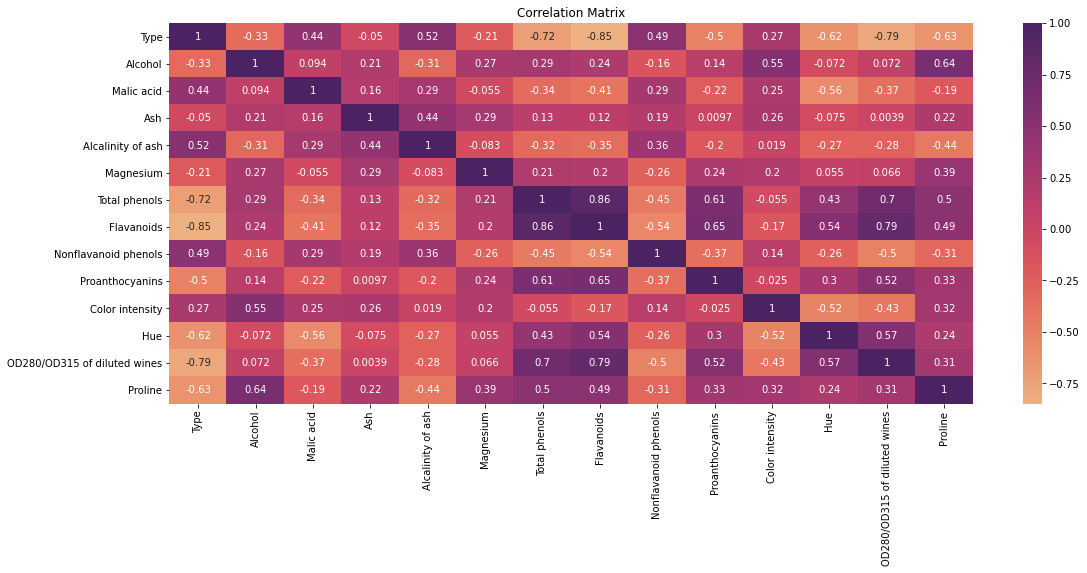

In [78]:
# Correlation
plt.figure(figsize = (18, 7))
correlation = juice.corr()
sns.heatmap(correlation, cmap = "flare", annot = True)
plt.title("Correlation Matrix")
plt.show()

In [79]:
# Take a minute to find the column where the correlation value is greater than 0.75 at least twice
to_drop = "Flavanoids"

# Drop that column from the DataFrame
juice = juice.drop(to_drop, axis = 1)

### PCA

In [90]:
# Set up PCA and the X vector for diminsionality reduction
pca = PCA()
juice_X = juice.drop("Type", axis=1)

# Apply PCA to the wine dataset
transformed_X = pca.fit_transform(juice_X)

# Look at the percentage of variance explained by the different components
print(pca.explained_variance_ratio_)

[9.98098798e-01 1.73593305e-03 9.43282757e-05 4.89438533e-05
 1.04695097e-05 5.60981698e-06 2.79968212e-06 1.44536313e-06
 9.75418873e-07 3.94184513e-07 2.13661389e-07 8.91974959e-08]


In [93]:
X = pd.DataFrame(transformed_X)
y = juice["Type"]

In [99]:
# Split the transformed X and the y labels into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size = 0.25)


knn = KNeighborsClassifier()

# Fit knn to the training data
knn.fit(X_train, y_train)

# Prediction
y_pred = knn.predict(X_test)

#
pd.DataFrame({"Actual": y_test, "Predicted": y_pred})[:10]

,Actual,Predicted
157,3,1
109,2,2
41,1,1
35,1,1
152,3,2
95,2,1
122,2,2
137,3,3
78,2,3
31,1,1


In [100]:
score = accuracy_score(y_test, y_pred)
score

0.5777777777777777

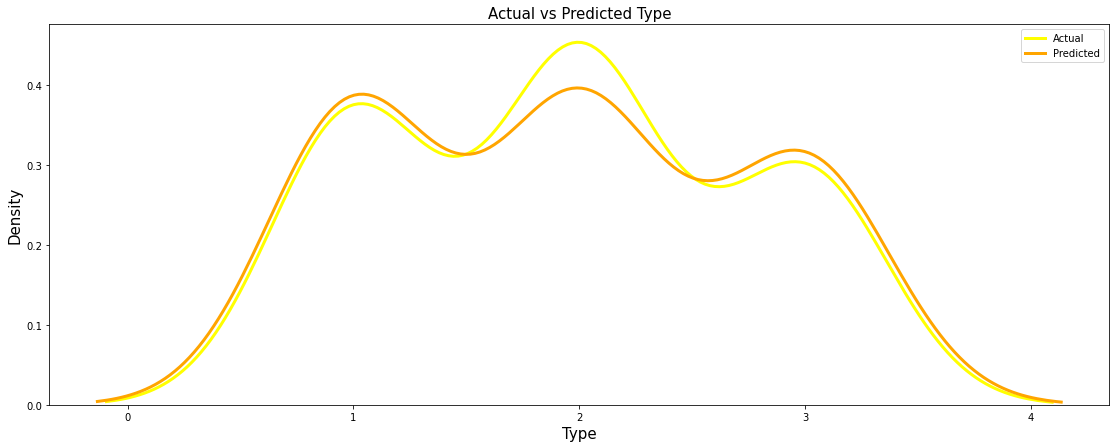

In [102]:
plt.figure(figsize = (19, 7))
sns.kdeplot(x = y_test, label = "Actual", linewidth = 3, color = "yellow")
sns.kdeplot(y_pred, label = "Predicted", linewidth = 3, color = "orange")
plt.title("Actual vs Predicted Type", size = 15)
plt.xlabel("Type", size = 15)
plt.ylabel("Density", size = 15)
plt.legend()
plt.show()